# Risk Modeling

**Zielsetzung und Vorgehen**

Dieses Notebook entwickelt das finale Risikomodell, das unmittelbar aus den zuvor geprüften Hypothesen abgeleitet wird.  
Die explorative Analyse und die Hypothesentests haben gezeigt, welche Faktoren systematisch mit der Unfallrate pro Fahrt zusammenhängen.  
Das Modell fasst diese Effekte nun in einer klaren, transparenten Struktur zusammen.

Der Ansatz ist bewusst einfach und nachvollziehbar gehalten:  
Ein Poisson-GLM eignet sich für seltene Zähldaten und erlaubt über den log-Offset für die Exposure die direkte Schätzung der Unfallrate pro Fahrt.  
Die resultierenden Koeffizienten sind interpretierbar und bilden die Grundlage für ein risikobasiertes Scoring – ein entscheidender Aspekt für praxisnahe Versicherungsanwendungen.

Das Modell hat dabei nicht den Anspruch, jedes Detail der realen Verkehrsdynamik abzubilden.  
Es soll zeigen, wie sich räumliche, zeitliche und nutzungsspezifische Effekte sauber miteinander kombinieren lassen und wie aus den getesteten Hypothesen ein konsistentes Risikomodell entsteht.

In [3]:
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import os

import sys
sys.path.append("../..")

from utils.paths import FIGURES_DIR
from utils.paths import DATA_MODEL
from utils.model_summary import custom_summary

# Unterordner für dieses Notebook
FIG_SUBDIR = "04_risk_analysis"
figures_path = os.path.join(FIGURES_DIR, FIG_SUBDIR)

# Ordner anlegen, falls nicht vorhanden
os.makedirs(figures_path, exist_ok=True)

## Setup und Laden der Daten

In [4]:
path_spatial_master = os.path.join(DATA_MODEL, 'exposure_master.parquet')
master = pd.read_parquet(path_spatial_master)

# Strukturübersicht des Datensatzes
print("Dimensionen des modellfertigen Datensatzes:", master.shape)

master.head()

Dimensionen des modellfertigen Datensatzes: (274993, 7)


,cell_idx,hour,season,rideable_type,exposure,crashes,exposure_decile
0,23,0,fall,classic_bike,1,0,2.0
1,23,0,fall,electric_bike,2,0,2.0
2,23,0,spring,classic_bike,3,0,2.0
3,23,0,summer,classic_bike,1,0,2.0
4,23,0,summer,electric_bike,3,0,2.0


## 1. Interpretation des finalen Risikomodells

Das Modell schätzt die erwartete Crash-Anzahl pro (Zelle × Stunde × Season × Bike-Typ).  
Über den log-Offset für die Exposure wird diese Erwartung auf eine Rate pro Fahrt normiert.  
Damit zeigt jeder Koeffizient, wie stark ein Faktor die Crashrate verändert – unabhängig davon, wie viele Fahrten in einer Gruppe stattfinden.

**Exposure-Deciles:**  
Die Koeffizienten sinken deutlich über die Deciles hinweg.  
Damit bestätigt das Modell den Safety-in-Numbers-Effekt:  
Zellen mit hoher Nutzung haben systematisch geringere Crashraten.

**Stunde:**  
Der Faktor „hour“ ist insgesamt stark wirksam.  
Nacht- und frühmorgendliche Stunden weisen die höchsten relativen Risiken auf.  
Einzelne Dummy-Kategorien sind statistisch unscharf, aber der Faktor als Ganzes bleibt stabil.

**Season:**  
Die Saisoneffekte sind moderat: Sommer leicht unterdurchschnittlich, Winter etwas erhöht.  
Diese Effekte entsprechen der EDA und sind im Modell klar abgegrenzt.

**Bike-Typ:**  
E-Bikes zeigen im Durchschnitt eine deutlich niedrigere modellierte Crashrate.  
Das liegt nicht am Fahrzeug selbst, sondern an unterschiedlichen räumlichen und zeitlichen Nutzungsstrukturen.  
Der Koeffizient sollte daher als realer Nutzungseffekt interpretiert werden, nicht als mechanischer Sicherheitseffekt.

**Overdispersion:**  
Die Dispersion liegt bei etwa 1.6 – moderat und für seltene Crashdaten erwartbar.  
Das Modell ist damit nicht überangepasst und liefert stabil interpretierbare Effekte.


In [5]:
model_final = smf.glm(
    formula=(
        "crashes ~ "
        "C(exposure_decile) + "
        "C(hour) + "
        "C(season) + "
        "C(rideable_type)"
    ),
    data=master,
    family=sm.families.Poisson(),
    offset=np.log(master["exposure"])
).fit()

custom_summary(model_final)


  Kompakte Modell-Summary

Anzahl Beobachtungen: 274993
Log-Likelihood:       -13554.81
Overdispersion:       1.598
(≈1 gut, 1–3 normal, >4 auffällig)

                          feature   coef exp(coef)    p_value ci_2.5% ci_97.5%
                        Intercept -4.899     0.007   2.67e-84  -5.393   -4.405
        C(exposure_decile)[T.1.0] -0.726     0.484    0.00407  -1.222   -0.231
        C(exposure_decile)[T.2.0] -1.121     0.326    4.7e-06  -1.601   -0.641
        C(exposure_decile)[T.3.0] -1.402     0.246    7.4e-09  -1.877   -0.927
        C(exposure_decile)[T.4.0] -1.553     0.212   8.43e-11  -2.022   -1.084
        C(exposure_decile)[T.5.0] -2.071     0.126    5.1e-18  -2.540   -1.602
        C(exposure_decile)[T.6.0] -2.300     0.100   2.99e-22  -2.765   -1.835
        C(exposure_decile)[T.7.0] -2.762     0.063   1.77e-31  -3.226   -2.298
        C(exposure_decile)[T.8.0] -3.196     0.041   6.31e-42  -3.658   -2.735
        C(exposure_decile)[T.9.0] -3.632     0.026   2.58

In [6]:
# Lineare Vorhersage (log-link)
master["mu_hat"] = model_final.predict(master)

# Crashrate = Erwartungswert / Exposure
master["crash_rate_hat"] = master["mu_hat"] / master["exposure"]

# Kontrolle
master[["cell_idx", "hour", "season", "rideable_type", 
        "exposure", "crashes", "crash_rate_hat"]].head()

,cell_idx,hour,season,rideable_type,exposure,crashes,crash_rate_hat
0,23,0,fall,classic_bike,1,0,0.002429
1,23,0,fall,electric_bike,2,0,0.000159
2,23,0,spring,classic_bike,3,0,0.000822
3,23,0,summer,classic_bike,1,0,0.002100
4,23,0,summer,electric_bike,3,0,0.000091


## 2. Vergleich von beobachteter und modellierter Crashrate

Zum Abschluss wird geprüft, wie gut das Modell die empirischen Muster der Unfallrate abbildet.  
Dazu wird die beobachtete Crashrate pro Exposure-Decile mit der durch das GLM geschätzten Rate verglichen.  
Die Decile-Glättung reduziert das Rauschen einzelner Zellen und zeigt, ob der modellierte Trend die realen Strukturen trifft.

Der Vergleich zeigt:  
- Der übergeordnete Zusammenhang (Safety-in-Numbers) wird klar reproduziert.  
- Die absolute Höhe der Crashraten wird systematisch unterschätzt – ein Hinweis auf unvermeidbares Rauschen und Overdispersion in seltenen Ereignisdaten.  
- Die Rangfolge der Deciles trifft das Modell zuverlässig, d. h. hohe Exposure-Größen werden korrekt als risikoärmer geschätzt.  

Formell könnte man die Modellgüte auch auf einem unabhängigen Testdatensatz, per Likelihood-Vergleich oder über Residuenanalysen prüfen.  
Für die hier betrachtete Fragestellung – ein erklärbares, strukturelles Risikomodell – reicht der decile-basierte Vergleich aus, um zu zeigen, welche Muster das Modell stabil erfasst und wo natürliche Grenzen liegen.

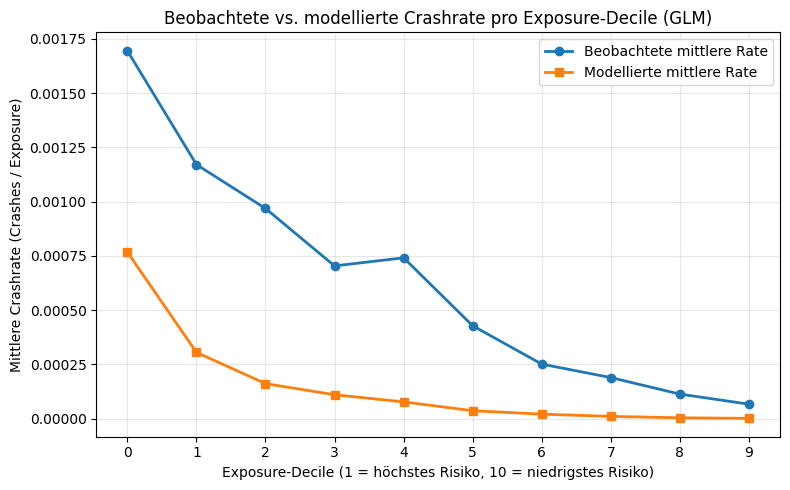

In [7]:
# Kopie des Datensatzes für die Vergleichsauswertung
df_check = master.copy()

# Beobachtete Crashrate pro Beobachtungseinheit
df_check["observed_rate"] = df_check["crashes"] / df_check["exposure"]

# Mittelwerte pro Exposure-Decile: Beobachtet vs. Modelliert
decile_eval = (
    df_check.groupby("exposure_decile", observed=True)[["observed_rate", "crash_rate_hat"]]
            .mean()
            .reset_index()
)

# Vergleich der beobachteten und modellierten Crashraten pro Exposure-Decile
fig, ax = plt.subplots(figsize=(8, 5))

# Beobachtete mittlere Crashrate
ax.plot(
    decile_eval["exposure_decile"].to_numpy(),
    decile_eval["observed_rate"].to_numpy(), 
    marker="o",
    linewidth=2,
    label="Beobachtete mittlere Rate",
)

# Modellierte Crashrate
ax.plot(
    decile_eval["exposure_decile"].to_numpy(),
    decile_eval["crash_rate_hat"].to_numpy(),
    marker="s",
    linewidth=2,
    label="Modellierte mittlere Rate",
)

# Achsenbeschriftungen und Layout
ax.set_title("Beobachtete vs. modellierte Crashrate pro Exposure-Decile (GLM)")
ax.set_xlabel("Exposure-Decile (1 = höchstes Risiko, 10 = niedrigstes Risiko)")
ax.set_ylabel("Mittlere Crashrate (Crashes / Exposure)")
ax.set_xticks(decile_eval["exposure_decile"].unique())

ax.grid(alpha=0.3)
ax.legend()

plt.tight_layout()

fig_path = os.path.join(figures_path, "crashrate_comparison_deciles.png")
plt.savefig(fig_path, dpi=300)

plt.show()

## 3. Micro-Insurance: Erwartungsschaden aus dem Risikomodell

Das GLM liefert für jede Fahrt eine geschätzte Crashrate  
$ \hat{\lambda}_i $, also die modellierte Wahrscheinlichkeit, dass Fahrt $i$ zu einem erfassten Unfall führt.

Für einen einfachen Expected-Loss-Ansatz werden folgende Annahmen getroffen:

1. **Konstante Schadenhöhe pro Unfall**  
   Die NYPD-Daten erfassen nur Unfälle ab ca. 1000 USD.  
   Für die Modellskizze wird daher ein fixer Schaden  
   $ C = 1000 \,\text{USD} $  
   verwendet.

2. **Erwartungsschaden pro Fahrt**  
   Der modellbasierte Erwartungswert des Schadens lautet:
   $$
   \mathbb{E}[S_i] = \hat{\lambda}_i \cdot C.
   $$

   Damit hat man eine sehr einfache Kenngröße, wie viel „Schadenrisiko“ eine einzelne Fahrt trägt.

3. **Hinweis zur späteren Prämienbildung**  
   Eine tatsächliche Mikroprämie würde auf dem Erwartungsschaden aufbauen und ein paar einfache Aufschläge enthalten:
   - **Sicherheitszuschlag** (falls das Modell die Raten eher unterschätzt)  
   - **Kosten** (IT, Transaktionen, Produktbetrieb)  
   - **Marge / Kapitalanforderungen** (kleiner Aufschlag für Ungewissheit)

